Лабораторная работа. MySQL.

Эта лабораторная работа имеет целью эмулировать процесс обработки данных, загрузку их в базу данных, обновление этих данных в базе, составление запросов к ней и выгрузку данных. Создавая и заполняя таблицы, проверяйте появление тех или иных элементов или записей в таблице в MySQL Workbench для большей наглядности.

Смодулируем небольшое исследование, которое разметит тексты по нескольким метрикам. Для этого используем небольшой датасет критики детской литературы отсюда: https://dataverse.pushdom.ru/dataset.xhtml?persistentId=doi:10.31860/openlit-2022.12-B008

**Глава 1. Метаданные**

Пушкинский дом подготавливает для нас описание корпуса, поэтому можно использовать табличку с метаданными для нашей работы.

In [1]:
import pandas as pd

In [45]:
path = 'keywords_titan_final.csv' 
meta = pd.read_csv(path) 
meta.drop(columns=['visiting_date', 'gender', 'Unnamed: 0'], inplace=True)
meta = meta.replace({pd.NA: None}) # заменяем na на питоновский None, чтобы sql мог с ним работать

In [46]:
meta.head()

,text,name,city_where_from,publication_date,object,platform,positives,negatives
0,Плохая работа персонала Сама экспозиция очень ...,kauspeh72,None,2020,derevo_musey,tonkosti,интересная экспозиция,"плохая работа персонала, не приветливые, сухо ..."
1,Здравствуйте! Это полная хрень. Развод на день...,AnnaFomina0112,Краснодар,2020,derevo_musey,otzovik,-,"полная хрень, развод на деньги, пусто, не инте..."
2,Посещали данный музей в рождество этого года. ...,Иродиада,Владимир,2020,derevo_musey,otzovik,-,"не радужное впечатление, серо, уныло, два полу..."
3,Этим летом проезжали Суздаль и решили посетить...,АНЯМАША,МОСКВА,2020,derevo_musey,otzovik,"мастер-класс пошагово все объясняла, время про...",-
4,"Посещали всей семьей этот музей, нам очень пон...",nastyasol1,Москва,2020,derevo_musey,otzovik,"приятный персонал, интересные экспонаты, больш...","экспонатов не так уж и много, обойти все можно..."


In [86]:
from nltk.corpus import stopwords

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('punkt_tab')
stop_words = set(stopwords.words('russian'))

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)


import re

## Определим функцию для лемматизации и извлечения именованных сущностей

In [104]:
def lemmatize_ner_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    entities = []
    lemmas = []
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        lm = token.lemma.lower()
        if len(lm) > 2 and re.match(r'^[а-яё]+$', lm) and lm not in stop_words:
            lemmas.append(lm)
    
    for span in doc.spans:
        entities.append(f'{span.text} -> {span.type}')
        
    return ', '.join(lemmas), ', '.join(entities)
    

## Создадим новый датафрейм для аналитики текстов отзывов

In [ ]:
results = meta['text'].apply(lemmatize_ner_text)
df_analysis = pd.DataFrame()
df_analysis['text'] = meta['text']
df_analysis['object'] = meta['object']
df_analysis['lemmas'], df_analysis['entities'] = zip(*results)
df_analysis.head()

,text,lemmas,entities
0,Плохая работа персонала Сама экспозиция очень ...,"плохой, работа, персонал, экспозиция, очень, и...",
1,Здравствуйте! Это полная хрень. Развод на день...,"здравствовать, это, полный, хрень, развод, ден...",
2,Посещали данный музей в рождество этого года. ...,"посещать, данный, музей, рождество, год, впеча...",Да Дерево -> PER
3,Этим летом проезжали Суздаль и решили посетить...,"это, лето, проезжать, суздаль, решить, посетит...","Суздаль -> LOC, Музей деревянного зодчества ->..."
4,"Посещали всей семьей этот музей, нам очень пон...","посещать, весь, семья, музей, очень, понравить...",


Как видно, в табличке есть вся нужная метаинформация по корпусу. Создадим отдельную базу данных и сохраним туда эту табличку. Назначим номер первичным ключом.

In [ ]:
import mysql.connector

In [20]:
with open('password_db.txt') as file:
    password = file.read().strip()

In [21]:
mydb = mysql.connector.connect(
    host = 'localhost',
    user = "root",
    password = password 
)

mycursor = mydb.cursor()
mycursor.execute("SHOW DATABASES")

for database in mycursor:
  print(database)

('information_schema',)
('linguistics',)
('multitran',)
('mysql',)
('new_schema',)
('obscenity',)
('performance_schema',)
('sys',)
('world',)


In [22]:
mydb = mysql.connector.connect(
  host = "localhost",
  user = "root",
  password = password   
)

mycursor = mydb.cursor()
mycursor.execute("CREATE DATABASE reviews") #создаём пока только саму БД с названием critics

Загрузим табличку с метаинформацией в БД. Заполним её таким же образом, как было в семинарском занятии по Python + SQL. Библиографию брать не будем. Для этого извлечем кортежи, т.е. строки, из пандасовского датафрейма.

In [ ]:
for_db = [row for row in meta.itertuples(index=True, name=None)]
for_db[:10]

Создадим пустую табличку.

Для начала посмотрим, какие таблички уже есть в БД:

Пусто! Создадим таблицу.

In [198]:
mydb = mysql.connector.connect(
    host = "localhost",
    user = "root",
    password = password,
    database = 'reviews'
)

mycursor = mydb.cursor()

In [72]:
mycursor.execute('DROP TABLE IF EXISTS meta')

In [73]:
mycursor.execute("CREATE TABLE IF NOT EXISTS meta (id INT PRIMARY KEY, text TEXT, name VARCHAR(50), city_where_from VARCHAR(50), publication_date YEAR, object VARCHAR(50), platform VARCHAR(300), positives VARCHAR(1000), negatives VARCHAR(1000))")

Проверим еще раз.

In [74]:
mycursor.execute("SHOW TABLES")

for table in mycursor:
  print(table)

('meta',)


Теперь заполним эту таблицу полученной ранее информацией.

In [75]:
sql = "INSERT INTO meta (id, text, name, city_where_from, publication_date, object, platform, positives, negatives) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"

mycursor.executemany(sql, for_db) 
mydb.commit() #не забудьте делать коммит, иначе не сохранится запись в БД

In [81]:
sql = "SELECT text FROM meta"
mycursor.execute(sql)
myresult = mycursor.fetchall()
for text in myresult[:10]:
    print(text)

('Плохая работа персонала Сама экспозиция очень интересная...., но общее впечатление испортило отношение персонала, не приветливые уже в начале , на кассе и так по всей территории. На вопросы , которые возникали по ходу просмотра экспозиции отвечали сухо и неохотно..., часто был ответ : Читайте на табличке)). ходили с ощущением, что нам здесь не рады).\n05 ноября 2020',)
('Здравствуйте! Это полная хрень. Развод на деньги. Пусто, не интересно. Не понимаю что людям может нравиться. Ребёнку заняться совсем не чем.',)
('Посещали данный музей в рождество этого года. Впечатление скажем прямо не радужное, серо, уныло. была заявлена неплохая развлекательная программа на которую мы и клюнули. \n\n\n    \n        \n    \n\n\nПо факту не было почти ничего Два полупьяных ведущих кривляющихся у микрофона в костюмах непонятно кого, и несколько человек детишек возраста примерно лет десяти тоже в костюмах которые сбились в кучку и молча отбывали время. и куцый хоровод из таких же как мы несчастных пыт

In [114]:
mycursor.execute('DROP TABLE IF EXISTS text_analysis')

In [115]:
mycursor.execute('CREATE TABLE IF NOT EXISTS text_analysis(text_id INT, text TEXT, lemmas TEXT, entities TEXT, object VARCHAR(300))')

## Подготовим данные для записи в новую таблицу

In [ ]:
analysis_for_db = [row for row in df_analysis.itertuples(index=True, name=None)]
analysis_for_db[:10]

## Собственно запишем данные в новую таблицу нашей базы данных

In [116]:
sql = 'INSERT INTO text_analysis(text_id, text, lemmas, entities, object) VALUES(%s, %s, %s, %s, %s)'
mycursor.executemany(sql, analysis_for_db)
mydb.commit()

## Добавим внешний ключ по основной таблице

In [117]:
mycursor.execute("ALTER TABLE text_analysis ADD FOREIGN KEY (text_id) REFERENCES meta(id)")

**Глава 4. Аналитика.**

Все наши дальнейшие действия крайне тривиальны: нам нужно получать выгрузку и что-то анализировать. Давайте посчитаем корреляции по записям в нашей БД.

## Некоторые танцы с бубном, чтобы достать именованные сущности из БД

In [169]:
sql = '''SELECT entities FROM text_analysis WHERE entities IS NOT NULL
AND entities <> ''
AND entities LIKE '%->%'
'''
mycursor.execute(sql)
myresult = mycursor.fetchall()
ents = []
for (ent_string, ) in myresult:
    chunks = [chunk.strip() for chunk in ent_string.split(',') if '->' in chunk]
    
    for chunk in chunks:
        entity_text, _ = chunk.split('->', 1)
        ents.append(entity_text)
        
ents = [ent for ent in ents if len(ent) > 3 and re.match(r'[а-яё]', ent.lower())]
ents = ' '.join(set(ents))

## Сделаем облако именованных сущностей

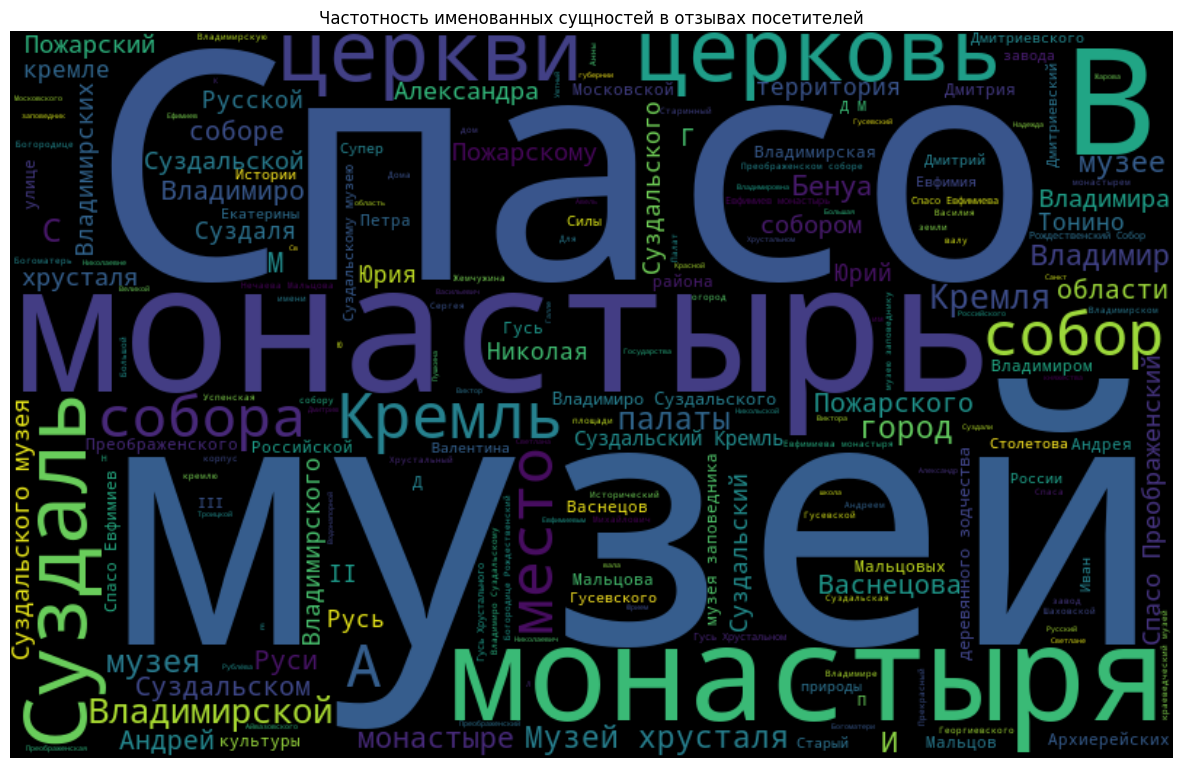

In [170]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=500).generate(ents)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Частотность именованных сущностей в отзывах посетителей')
plt.show()

## Сделаем несколько запросов SELECT

In [ ]:
# выберем позитивные слова о музее дер. зодчества за 20 год
sql = '''
SELECT positives FROM meta WHERE object='derevo_musey' AND publication_date='2020' AND positives!='-'
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

('интересная экспозиция',)
('мастер-класс пошагово все объясняла, время пролетело незаметно, впечатления великолепные',)
('приятный персонал, интересные экспонаты, большая территория, мастер классы, природа, свежий воздух, чистая территория, здания прошлого, яркие впечатления',)
('интересный и информативный музей',)
('интересная конструкция, интересный музей, быт крестьян',)
('интересные экспонаты, возможность узнать больше о жизни, информационные таблички',)
('красивый музей, интересные постройки',)
('уникальные экспонаты, интересная экспозиция, спокойная атмосфера, прекрасная погода',)
('релаксово место, тихо, спокойно, хорошо, деревяненькае постройки, много открытого пространства',)
('интересное, волшебное место, красивые фото, русский народный наряд',)


In [ ]:
# сколько отзывов длиннее 1000 знаков об объектах с названием музей
sql = '''
SELECT COUNT(*) FROM meta WHERE CHAR_LENGTH(text)>1000 and object LIKE '%_musey'
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

(47,)


In [ ]:
# в скольких отзывах упоминаются именованные сущности с тегом LOCATION
sql = '''
SELECT COUNT(*) FROM text_analysis WHERE entities LIKE '%-> LOC'
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

(1901,)


In [ ]:
# позитивные и негативные ключевые слова о музеях за 2024 год с упоминанием людей
sql = '''
SELECT m.positives AS pluses, m.negatives AS minuses FROM meta m
JOIN text_analysis a ON a.text_id = m.id
WHERE m.publication_date = 2024 AND a.entities LIKE '%PER%' AND m.object LIKE '%musey' AND positives != '-' AND negatives != '-'
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

('замечательный музей под открытым небом, уникальные экземпляры деревянных сооружений, деревянные настилы, зеленые насаждения, цветущие одуванчики, драгоценные "жемчужины" музея', 'нет новых экспонатов')
('быт и хозяйство предков, старинные предметы, интересно даже без экскурсовода, деревянные церкви, чудесный дядя Юра, забавный рассказ', 'нет льгот для пенсионеров')
('небанальные сувениры, ювелирные изделия с вышивкой, произведения искусства, приветливые работники, интересные музейные экспозиции, вкусный травяной чай', 'непонятно зачем покупать комплексные билеты за 1200')
('впечатлил храм, внутреннее убранство построек', 'пластиковые бутылки, салфетки, одноразовая посуда, высокий входной билет')
('избы с разными экспозициями, экскурсовод старалась', 'было холодно -27, битком народу')
('все ухожено и симпатично', 'дороговатый вход')
('шедевры', 'современники в шортах и майках, дресс-код')
('мастер класс по изготовлению сувенира из стекла, Настя - мастер своего дела', 'Сам музей не впе

In [215]:
mycursor.execute('DROP TABLE IF EXISTS statistics')

In [216]:
# создадим таблицу со статистикой по длине отзывов, если отзыв длиннее 1000 знаков, а также если в нем есть именованные сущности
sql = '''
CREATE TABLE IF NOT EXISTS statistics AS 
SELECT m.id, m.text, CHAR_LENGTH(m.text) AS text_length, a.entities
FROM meta m
JOIN text_analysis a ON m.id=a.text_id
WHERE CHAR_LENGTH(m.text) > 1000
AND m.object LIKE '%musey'
AND a.entities IS NOT NULL
'''
mycursor.execute(sql)
mydb.commit()

In [217]:
mycursor.execute('SHOW TABLES')
for table in mycursor:
    print(table)

('meta',)
('statistics',)
('text_analysis',)


In [220]:
mycursor.execute("ALTER TABLE statistics ADD FOREIGN KEY (id) REFERENCES meta(id)")

In [221]:
# какие сущности у нас соответствуют длинным отзывам
sql = '''
SELECT id, text_length, entities FROM statistics
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

(2, 1062, 'Да Дерево -> PER')
(5, 1362, 'Суздали -> LOC, Суздальского кремля -> LOC, Каменка -> LOC, Иркутском -> LOC, Владимирской области -> LOC, Владимиро-Суздальскому музею -> ORG, Суздали -> LOC')
(6, 6354, 'Суздале -> LOC, Кремле -> LOC, Спасо-Евфимиевском монастыре -> ORG, Музей -> ORG, Дом купцов -> ORG, Агаповых -> PER, Суздаль -> LOC, России -> LOC, Агаповы -> PER, Агаповых -> PER, Мельницы -> PER, Владимирской области -> LOC, Русское подворье -> ORG')
(7, 2183, 'Каменки -> LOC, Суздале -> LOC, Вязниковского района -> LOC, Суздале -> LOC, Преображенская церковь -> ORG, Козлятьево -> LOC, Поляны -> LOC, Воскресенская церковь -> ORG, Патакино -> LOC, Камешковского района -> LOC, Свияжске -> LOC, Суздальского музея -> ORG, Суздале -> LOC')
(8, 5621, 'Суздаль -> LOC, Владимирской области -> LOC, Суздале -> LOC, Суздальский музей -> ORG, Суздале -> LOC, Владимир -> LOC, Суздаль -> LOC, Золотому Кольцу -> LOC, Суздальского Кремля -> LOC, Суздальского музея -> ORG, Суздальского Крем

In [222]:
# вложенный запрос - выбрать тексты отзывов, в которых есть несколько именованных сущностей, а длина отзыва не более 200 знаков
sql = '''
SELECT text FROM meta
WHERE id IN (
    SELECT text_id
    FROM text_analysis
    WHERE entities IS NOT NULL 
    AND CHAR_LENGTH(entities) < 50
    AND CHAR_LENGTH(text) < 200
)
'''
mycursor.execute(sql)
result = mycursor.fetchall()
for text in result[:10]:
    print(text)

('Здравствуйте! Это полная хрень. Развод на деньги. Пусто, не интересно. Не понимаю что людям может нравиться. Ребёнку заняться совсем не чем.',)
('Очень релаксовое место. Тихо, спокойно, хорошо. Все деревянненькое. Во многие постройки можно заходить))) Много открытого пространства. Погулять в удовольствие)',)
('Рекомендую посетить - интересное, волшебное место. Летом можно сделать красивые фото. И там я одевала русский народный наряд.',)
('Посещение на один раз. На всю территорию 10 строений. Всё закрыто, таблички с информацией очень скудные.',)
('Нам все очень понравилось, интересная экспозиция, приветливые и отзывчивые сотрудники музея. Есть мастер-классы для детей. Все на уровне.\nНа территории есть действующая церковь.',)
('Невероятное  место! Очень  понравились гуляния на Масленицу. Организация в этом месте  была на высоте и мастер классы и концерт и танцы и гусиные бои. Были первый раз в Суздале и в восторге!',)
('Если вы прибыли в Россию или хотите узнать как жили крестьяне на 

In [223]:
import subprocess

database = 'reviews'
dump_file = 'DB_lab.sql'
user = 'root'
host = 'localhost' 


cmd = [
    'mysqldump',
    f'-u{user}',
    f'-p{password}',
    f'-h{host}',
    database
]

with open(dump_file, 'w', encoding='utf-8') as file:
    result = subprocess.run(cmd, stdout=file)
    
if result.returncode == 0:
    print('Дамп успешно сохранен')
    
else:
    print('Возникла ошибка')


Дамп успешно сохранен


mysqldump: [Warning] Using a password on the command line interface can be insecure.


**Глава 5. Свободное искусство (то есть задание для самостоятельной работы).**

Ваша задача выбрать какой-либо датасет (не слишком большой - вы не должны сделать итоговый проект в рамках этой работы, хотя итоговый проект во многом должен быть похож именно на эту лабораторную работу) из множества датасетов Пушкинского дома ( https://dataverse.pushdom.ru/) и обработать его.

Задания:
1) выбрать датасет;
2) создать БД с несколькими таблицами, которые будут отображать всё великолепие и многообразие датасета (мета-, тексты, статистические подсчёты);
3) заполнить эти таблицы;
4) придумать небольшое исследование: например, корреляцию количества определенных частей речи с количеством повторений слова "запонка" в тексте. Достаточно 1-2 метрик, это игрушечное исследование, а не заготовка вашей статьи;
5) проиллюстрировать ваше умение создавать таблицы, заполнять таблицы, получать выгрузку, обновлять таблицы и данные в них;
6) также напишите 5-6 комбинаторных запросов. Например, "подсчёт числа текстов, написанных до 1927 года". Попробуйте придумать максимально сложные для рассматриваемого вами датасета;
7) Напишите хотя бы один вложенный запрос;
8) Сделайте один разумный JOIN и обоснуйте его.

Оцениваться будет ваше умение аккуратно писать и обосновывать запросы. Комментируйте большинство строчек кода, надписав, что делает эта строчка. Каждый недублирующийся SQL запрос распишите, что он последовательно делает.

Помимо семинарских занятий 3 модуля вам могут быть полезны выложенные учебники, а также онлайн-справочники, а особенно следующие  главы:
1) https://www.w3schools.com/sql/default.asp
2) https://www.w3schools.com/sql/sql_join.asp
3) https://www.w3schools.com/sql/sql_alter.asp
4) https://www.w3schools.com/sql/sql_insert.asp
5) https://www.w3schools.com/sql/sql_update.asp


Пришлите до 15.05 включительно на почту a.klimov@hse.ru архив с такой же тетрадкой, где выполнены и прокомментированы задания, а также дамп и схема вашей БД. По желанию можно прислать csv таблицы выгрузок.